_________________________________________________________________________

# **Data Scientist Test Task [v2.0] inPowered** 


Optimizing CPE across groups <br> <br>


Rafael Henrique Martello

_________________________________________________________________________

# [03] Model

## Libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Processing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler


# Feature Selection
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from lightgbm import LGBMRegressor


# Model
from lazypredict.Supervised import LazyRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split




# Hyperparameters
import optuna

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score


# Saving data

import json
import pickle


# import shap

# from sklearn.metrics import auc
# from sklearn.metrics import RocCurveDisplay
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# from sklearn.metrics import precision_recall_curve





<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Model

### 1 - Data Normalization

In [2]:
data = pd.read_parquet('Data/Processed/data_trated.parquet')

X = data.drop('cpe', axis=1)
y = data['cpe']

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()



# Preprocessing pipelines for numerical and categorical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])


In [3]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test, train_index, test_index = train_test_split(X, y, X.index, test_size=0.33, random_state=42)

In [4]:

index_train = train_index
index_test = test_index

In [5]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [6]:

one_hot_features = preprocessor.transformers_[1][1]\
   .named_steps['onehot'].get_feature_names_out(categorical_features)
vars = numerical_features + list(one_hot_features)

In [7]:
X_train = pd.DataFrame(X_train, index=index_train, columns=vars)
X_test =pd.DataFrame(X_test, index=index_test, columns=vars)

### 2 - Feature Selection

In [8]:
# This combined variable selection method was created by me some time ago,
# it is usually very useful to reduce the number of features and ends up having

## Pearson:
def correlation(X, y, num_feats):
    '''
    Select features by Correlation
    '''
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]

    return cor_support, cor_feature

## VarianceThreshold
def variance(X, y, num_feats):
    '''
    Select features by Variance Threshold
    '''

    embeded_var_selector = VarianceThreshold(threshold=(.1))
    embeded_var_selector.fit(X)

    embeded_var_support = embeded_var_selector.get_support()
    embeded_var_feature = X.loc[:,embeded_var_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')
    
    return embeded_var_support, embeded_var_feature

## Lasso:
def lasso(X, y, num_feats):
    '''
    Select features by L1 penalty in Linear Regression
    '''
    embeded_lr_selector = SelectFromModel(Lasso(alpha=0.01), max_features=num_feats)
    embeded_lr_selector.fit(X, y)

    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    #print(str(len(embeded_lr_feature)), 'selected features')
    
    return embeded_lr_support, embeded_lr_feature

## Random Forest:
def random_forest(X, y, num_feats):
    '''
    Select features using Random Forest
    '''
    embeded_rf_selector = SelectFromModel(RandomForestRegressor(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')
    
    return embeded_rf_support, embeded_rf_feature

def ensemble(X, y, num_feats):
    '''
    Select features using Ensemble LightGBM
    '''
    lgbc = LGBMRegressor(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                          reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)

    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    return embeded_lgb_support, embeded_lgb_feature

## RFE:
def recursive(X, y, num_feats, model):
    '''
    Select features using the provided estimator
    '''

    rfe_selector = RFE(estimator=model, n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    #print(str(len(rfe_feature)), 'selected features') 

    return rfe_support, rfe_feature

## Permutation importance
def permutation(X, y, num_feats, model):
    '''
    Select features using permutation
    '''
    model.fit(X, y)
    r = permutation_importance(model, X, y, n_repeats=5, random_state=42)
    embeded_permutation_support = np.where(r.importances_mean > 0, True, False)
    embeded_permutation_feature = X.loc[:,embeded_permutation_support].columns.tolist()
    #print(str(len(embeded_rf_feature)), 'selected features')

    return embeded_permutation_support, embeded_permutation_feature

def feature_selection(X, y, num_feats, model=None):
    '''
    Combined feature selection method
    '''
    feature_name = X.columns.tolist()
    X_norm = MinMaxScaler().fit_transform(X)
    X_norm = pd.DataFrame(X_norm, columns=feature_name)
    
    ## Pearson
    cor_support, cor_feature = correlation(X, y, num_feats)
    
    ## VarianceThreshold
    embeded_var_support, embeded_var_feature = variance(X, y, num_feats)
    
    ## Lasso
    embeded_lr_support, embeded_lr_feature = lasso(X_norm, y, num_feats)
    
    ## Random Forest
    embeded_rf_support, embeded_rf_feature = random_forest(X, y, num_feats)
    
    ## Ensemble
    embeded_lgb_support, embeded_lgb_feature = ensemble(X, y, num_feats)
    
    ## RFE
    rfe_support, rfe_feature = recursive(X_norm, y, num_feats, model)
    
    ## Permutation
    embeded_permutation_support, embeded_permutation_feature = permutation(X_norm, y, num_feats, model)

    # put all selection together
    feature_selection_df = pd.DataFrame({'Feature': feature_name, 
                                         'Pearson': cor_support, 
                                         'Variance': embeded_var_support, 
                                         'Lasso': embeded_lr_support,
                                         'Random Forest': embeded_rf_support,
                                         'Ensemble': embeded_lgb_support,
                                         'RFE': rfe_support, 
                                         'Permutation': embeded_permutation_support
                                         })

    # count the selected times for each feature
    feature_selection_df['Total'] = np.sum(feature_selection_df.iloc[:, 1:].astype(bool), axis=1)

    # display the top 100
    feature_selection_df = feature_selection_df.sort_values(['Total', 'Feature'], ascending=False)
    feature_selection_df.index = range(1, len(feature_selection_df) + 1)
    #feature_selection_df.head(num_feats)
    return feature_selection_df

model = XGBRegressor()

# Apply the feature selection function
df_features = feature_selection(X=X_train, y=y_train, num_feats=20, model=model)


Fitting estimator with 39 features.
Fitting estimator with 29 features.


In [9]:
df_features

,Feature,Pearson,Variance,Lasso,Random Forest,Ensemble,RFE,Permutation,Total
1,media_cpc,True,True,True,True,True,True,True,7
2,engagements,True,True,True,True,True,True,True,7
3,bid,True,True,True,True,True,True,True,7
4,active_days,True,True,True,True,True,True,True,7
5,media_spend,True,True,False,True,True,True,True,6
6,page_views,False,True,False,True,True,True,True,5
7,item,False,True,True,False,True,True,True,5
8,clicks,False,True,False,True,True,True,True,5
9,IABCategory_Travel,True,True,True,False,False,True,True,5
10,targetGender_MALE;,True,True,False,False,False,True,True,4


In [10]:
# selecting features that are relevant in at least 3 methods 

selected_features_df = df_features[df_features.Total > 3]
selected_features = selected_features_df.Feature.values

In [11]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [12]:
X_train.shape

(1126, 15)

### 3 - Comparing models

In [13]:
lz = LazyRegressor(predictions=True)
lz_df, predictions = lz.fit(X_train, X_test, y_train, y_test)

100%|██████████| 42/42 [00:03<00:00, 13.85it/s]


In [14]:
lz_df.sort_values(by='R-Squared', ascending=False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
GradientBoostingRegressor,0.95,0.95,0.19,0.19
XGBRegressor,0.94,0.94,0.22,0.08
RandomForestRegressor,0.92,0.92,0.24,0.55
BaggingRegressor,0.90,0.91,0.27,0.07
ExtraTreesRegressor,0.90,0.90,0.28,0.30
LGBMRegressor,0.90,0.90,0.28,0.06
HistGradientBoostingRegressor,0.89,0.90,0.28,0.17
MLPRegressor,0.87,0.88,0.31,0.63
DecisionTreeRegressor,0.84,0.84,0.35,0.01


#### 3.1 - DummyRegressor

In [15]:
# First we can make a DummyRegressor to have a minimum reference
# as a baseline strategy

dummy_clf = DummyRegressor()
dummy_clf.fit(X_train, y_train)
y_pred = dummy_clf.predict(X_test)
dummy_clf.score(X_test, y_test)

-0.0001833330100284858

In [16]:

def generate_regression_metrics(y_true, y_pred):
    '''
    Function to generate model metrics for regression
    '''
    # Calculating metrics
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    explained_variance = explained_variance_score(y_true, y_pred)
    
    # Creating a DataFrame for the metrics table
    metrics_df = pd.DataFrame({
        'Metric': ['Mean Squared Error (MSE)', 'Mean Absolute Error (MAE)', 'R-Squared (R2)', 'Root Mean Squared Error (RMSE)', 'Explained Variance'],
        'Value': [mse, mae, r2, rmse, explained_variance]
    })
    
    return metrics_df


# Example usage
# y_test and y_pred should be defined prior to this function call
metrics = generate_regression_metrics(y_test, y_pred)
print(metrics)


                           Metric  Value
0        Mean Squared Error (MSE)   0.79
1       Mean Absolute Error (MAE)   0.61
2                  R-Squared (R2)  -0.00
3  Root Mean Squared Error (RMSE)   0.89
4              Explained Variance   0.00


#### 3.2 - GradientBoosting

In [17]:
reg = GradientBoostingRegressor(random_state=42)


reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
reg.score(X_test, y_test)



0.9540950480689742

In [18]:
metrics = generate_regression_metrics(y_test, y_pred)
print(metrics)

                           Metric  Value
0        Mean Squared Error (MSE)   0.04
1       Mean Absolute Error (MAE)   0.10
2                  R-Squared (R2)   0.95
3  Root Mean Squared Error (RMSE)   0.19
4              Explained Variance   0.95


### 4 - Hyperparameter Optimization

In [19]:
def train_xgb(X_train, y_train, X_test, y_test, **params):
    '''
    Train function for XGB Optuna
    '''
    xgb = XGBRegressor(
        random_state=42, 
        **params
    )
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    return explained_variance_score(y_test, y_pred)


def train_gboost(X_train, y_train, X_test, y_test, **params):
    '''
    GradientBoostingRegressor optuna fuction for training
    '''
    gboost = GradientBoostingRegressor(
        random_state=42, 
        **params
    )
    gboost.fit(X_train, y_train)
    y_pred = gboost.predict(X_test)
    return explained_variance_score(y_test, y_pred)




def objective_xgb(trial):
    '''
    Objective Function for XGB
    '''
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 1.0),
    }


    score = train_xgb(X_train, y_train, X_test, y_test, **params)

    return score



def objective_gboost(trial):
    '''
    objective function for gboost
    '''
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 1000),
        'max_features': trial.suggest_categorical('max_features', ["sqrt", "log2"]),
        'min_samples_leaf': trial.suggest_float('min_samples_leaf' , 0.01 , 1.0) ,
        'min_samples_split': trial.suggest_int('min_samples_split' , 2, 15),
        'loss': trial.suggest_categorical('loss', ['squared_error', 'absolute_error', 'huber', 'quantile'])
    }

    score = train_gboost(X_train, y_train, X_test, y_test, **params)

    return score

In [20]:
models_dict = {'XGBRegressor': [XGBRegressor, objective_xgb],
               'GradientBoostingRegressor': [GradientBoostingRegressor, objective_gboost]
              }

In [21]:
# Rodar optuna

model_selection_dict = {}

for model in list(set(['XGBRegressor', 'GradientBoostingRegressor'])):
    sampler = optuna.samplers.TPESampler(seed=42)  # Make the sampler behave in a deterministic way.
    study = optuna.create_study(direction='maximize', sampler=sampler)
    study.optimize(models_dict[model][1], n_trials = 500)
    trial = study.best_trial
    try:
        model_temp = models_dict[model][0](random_state=42, **trial.params)
        params = trial.params
        params['random_state'] = 42
    except:
        model_temp = models_dict[model][0](**trial.params)
        params = trial.params
    model_selection_dict[model] = params

[I 2024-05-20 13:08:29,545] A new study created in memory with name: no-name-a246f906-aad1-437c-870e-a5ec03828671
[I 2024-05-20 13:08:29,963] Trial 0 finished with value: 0.7348550087132116 and parameters: {'max_depth': 4, 'learning_rate': 0.951207163345817, 'n_estimators': 746, 'max_features': 'sqrt', 'min_samples_leaf': 0.16443457513284063, 'min_samples_split': 2, 'loss': 'squared_error'}. Best is trial 0 with value: 0.7348550087132116.
[I 2024-05-20 13:08:30,232] Trial 1 finished with value: 0.552044818095343 and parameters: {'max_depth': 10, 'learning_rate': 0.8341182143924175, 'n_estimators': 251, 'max_features': 'log2', 'min_samples_leaf': 0.31119982052994233, 'min_samples_split': 9, 'loss': 'huber'}. Best is trial 0 with value: 0.7348550087132116.
[I 2024-05-20 13:08:30,466] Trial 2 finished with value: -2.220446049250313e-16 and parameters: {'max_depth': 3, 'learning_rate': 0.37269822486075477, 'n_estimators': 483, 'max_features': 'sqrt', 'min_samples_leaf': 0.5190920940294755,

In [22]:


# Convert and write JSON object to file
with open("Model/hyperparameters/gboost.json", "w") as outfile: 
    json.dump(model_selection_dict['GradientBoostingRegressor'], outfile)


In [23]:
parameters = model_selection_dict['GradientBoostingRegressor']

### 5 - Pipeline

In [24]:

# Identify numerical and categorical columns
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()



# Preprocessing pipelines for numerical and categorical data
numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ])

# Create a pipeline that combines preprocessing and model training
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(**parameters))
])


In [25]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [26]:
model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)

In [27]:
metrics = generate_regression_metrics(y_test, y_pred)
print(metrics)

                           Metric  Value
0        Mean Squared Error (MSE)   0.07
1       Mean Absolute Error (MAE)   0.13
2                  R-Squared (R2)   0.91
3  Root Mean Squared Error (RMSE)   0.27
4              Explained Variance   0.91


In [28]:
import joblib
joblib.dump(model_pipeline, 'Model/model_pipeline_save1.pkl') 

['Model/model_pipeline_save1.pkl']

In [29]:
import pickle
import gzip

with gzip.open('Model/model_pipeline_save2.pkl', 'wb') as f:
    pickle.dump(model_pipeline, f)

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def generate_response_surface(model, X, var1, var2, grid_size=50):
    '''
    Generate a response surface by varying two variables.
    
    Parameters:
    - model: Trained ML model.
    - X: DataFrame of input features.
    - var1: The first variable to vary.
    - var2: The second variable to vary.
    - grid_size: Number of points to generate along each axis.
    
    Returns:
    - X1: Grid of var1 values.
    - X2: Grid of var2 values.
    - Y: Predicted values for each combination of var1 and var2.
    - X_pred: DataFrame with the grid values and corresponding predictions.
    '''
    # Generate a grid of values for var1 and var2
    x1 = np.linspace(X[var1].min(), X[var1].max(), grid_size)
    x2 = np.linspace(X[var2].min(), X[var2].max(), grid_size)
    X1, X2 = np.meshgrid(x1, x2)

    # Prepare the data for prediction
    X_pred = pd.DataFrame({var1: X1.ravel(), var2: X2.ravel()})
    
    # Add mean values for other features
    for col in X.columns:
        if col not in [var1, var2]:
            X_pred[col] = X[col].mean()

    # Make predictions
    X_pred['Prediction'] = model.predict(X_pred)

    # Reshape predictions to match the grid shape
    Y = X_pred['Prediction'].values.reshape(X1.shape)

    return X1, X2, Y, X_pred

def plot_response_surface(X1, X2, Y, var1, var2):
    '''
    Plot the response surface.
    
    Parameters:
    - X1: Grid of var1 values.
    - X2: Grid of var2 values.
    - Y: Predicted values for each combination of var1 and var2.
    - var1: The first variable.
    - var2: The second variable.
    '''
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1, X2, Y, cmap='viridis')

    ax.set_xlabel(var1)
    ax.set_ylabel(var2)
    ax.set_zlabel('Prediction')
    ax.set_title(f'Response Surface: {var1} vs {var2}')

    plt.show()

# Example usage
# Assuming you have a trained model and a dataset X
# Replace 'var1' and 'var2' with the names of the variables you want to vary
var1 = 'bid'
var2 = 'budget'



In [31]:
index_x = X.index
X_processed = model_pipeline['preprocessor'].transform(X)

X_processed =pd.DataFrame(X_processed, index=index_x, columns=vars)

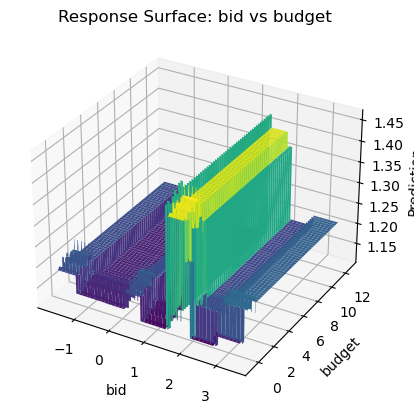

In [38]:

X1, X2, Y, X_pred = generate_response_surface(model_pipeline['regressor'], X_processed, var1, var2, grid_size=500)
plot_response_surface(X1, X2, Y, var1, var2)

In [33]:
def plot_response_surface_2d(X1, X2, Y, var1, var2):
    '''
    Plot the 2D response surface.
    
    Parameters:
    - X1: Grid of var1 values.
    - X2: Grid of var2 values.
    - Y: Predicted values for each combination of var1 and var2.
    - var1: The first variable.
    - var2: The second variable.
    '''
    plt.figure(figsize=(10, 6))
    contour = plt.contourf(X1, X2, Y, cmap='viridis', levels=50)
    plt.colorbar(contour)
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.title(f'Response Surface: {var1} vs {var2}')
    plt.show()


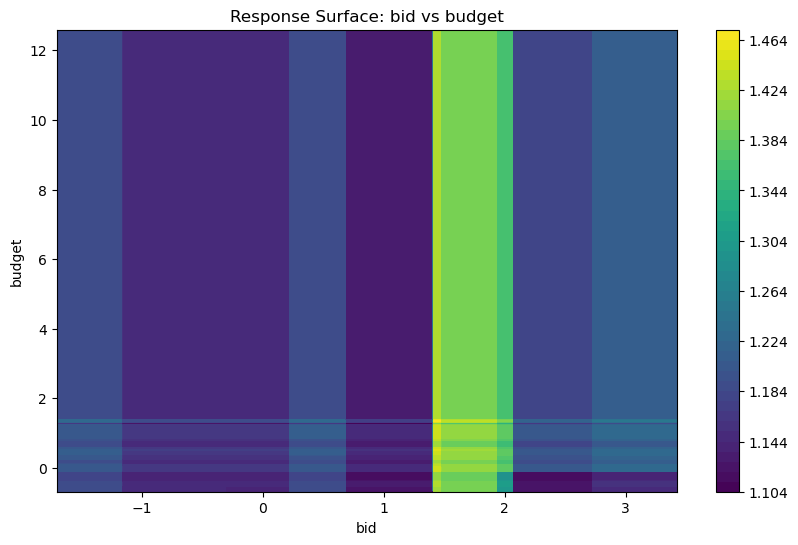

In [39]:
# Plot the 2D response surface
plot_response_surface_2d(X1, X2, Y, var1, var2)

In [41]:
# Find the minimum predicted value and the corresponding row
min_index = X_pred['Prediction'].idxmin()

min_value = X_pred.loc[min_index, 'Prediction']
min_row = pd.DataFrame(model_pipeline['preprocessor'].transformers_[0][1].inverse_transform(pd.DataFrame(X_pred.loc[min_index, :]).T[numerical_features]), columns=numerical_features)


print(f"Minimum predicted value: {min_value}")
print(f"Corresponding values:\n{min_row.loc[:, [var1, var2]].iloc[0]}")

Minimum predicted value: 1.109257548933208
Corresponding values:
bid        0.60
budget   383.11
Name: 0, dtype: float64
